In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sncosmo
import emcee
from multiprocessing import Pool
import glob
import quadpy
from matplotlib.offsetbox import AnchoredText
import getdist
from getdist import plots, MCSamples
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

gk = quadpy.c1.gauss_kronrod(40)

In [2]:
pantheon_ori_fits=pd.read_csv("pantheon_original_fit.txt",sep="\s+")

## Carregando dados EXP

In [3]:
glob.glob("./lc_fit_results*.txt")

['./lc_fit_results_EXP_FA_PS1_Pantheon.txt',
 './lc_fit_results_EXP_FA_SNLS_Pantheon.txt',
 './lc_fit_results_EXP_FA_HST_Pantheon.txt',
 './lc_fit_results_EXP_FA_SDSS_Pantheon.txt',
 './lc_fit_results_EXP_FA_LOWZ_Pantheon.txt']

In [4]:
SDSS_fits=pd.read_csv("./lc_fit_results_EXP_FA_SDSS_Pantheon.txt",sep="\s+")
SNLS_fits=pd.read_csv("./lc_fit_results_EXP_FA_SNLS_Pantheon.txt",sep="\s+")
PS1_fits=pd.read_csv("./lc_fit_results_EXP_FA_PS1_Pantheon.txt",sep="\s+")
HST_fits=pd.read_csv("./lc_fit_results_EXP_FA_HST_Pantheon.txt",sep="\s+")
LOWZ_fits=pd.read_csv("./lc_fit_results_EXP_FA_LOWZ_Pantheon.txt",sep="\s+")

In [5]:
df_exp_bf_cuts=pd.concat([PS1_fits,SNLS_fits,SDSS_fits,LOWZ_fits,HST_fits])

In [6]:
df_exp=df_exp_bf_cuts[(df_exp_bf_cuts["X1"]>-0.35) & (df_exp_bf_cuts["X1"]<0.25) &
                      (df_exp_bf_cuts["X2/C"]>-0.35) & (df_exp_bf_cuts["X2/C"]<0.35) &
                      (df_exp_bf_cuts["X1ERR"]>0.) & (df_exp_bf_cuts["X1ERR"]<1.) &
                      (df_exp_bf_cuts["X2/CERR"]>0.) & (df_exp_bf_cuts["X2/CERR"]<1.) &
                      (df_exp_bf_cuts["CHISQ/NDOF"]<=15.)].reset_index(drop=True)

## Carregando dados SALT2

In [7]:
glob.glob("./fits_SALT2/lc_fit_results*.txt")

['./fits_SALT2/lc_fit_results_SALT2_LOWZ_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_HST_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_SNLS_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_SDSS_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_PS1_Pantheon.txt']

In [8]:
SDSS_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_SDSS_Pantheon.txt",sep="\s+")
SNLS_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_SNLS_Pantheon.txt",sep="\s+")
PS1_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_PS1_Pantheon.txt",sep="\s+")
HST_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_HST_Pantheon.txt",sep="\s+")
LOWZ_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_LOWZ_Pantheon.txt",sep="\s+")

In [9]:
df_salt2_bf_cuts=pd.concat([PS1_fits_SALT2,SNLS_fits_SALT2,SDSS_fits_SALT2,LOWZ_fits_SALT2,HST_fits_SALT2])

In [10]:
df_salt2=df_salt2_bf_cuts[(abs(df_salt2_bf_cuts["X1"])<=3.) & (abs(df_salt2_bf_cuts["X2/C"])<=0.3)].reset_index(drop=True)

## MCMC

#### MCMC EXP

In [11]:
class cosmo:
    def __init__(self, data):
        self.data = data
        
    def dL(self,Ok, integral):
        if(Ok[0]>0.):
            return 1./np.sqrt(Ok[0])*np.sinh(np.sqrt(Ok[0])*np.array(integral))
        elif(Ok[0]==0.):
            return integral
        elif(Ok[0]<0.):
            return 1./np.sqrt(-Ok[0])*np.sin(np.sqrt(-Ok[0])*np.array(integral))
    
    def log_likelihood_exp(self,theta):
        alpha, beta, sigma=theta
        Om=0.3595
        Ol=0.4671
        M=16.0930
        deltaM=-0.03105

        Ok=1.-Om-Ol
        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+Ol+(1.-Om-Ol)*(1+x)**2.)
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])

        model=5*np.log10((1+self.data["z"])*self.dL(np.array([Ok]*len(integral)),integral))+M
        mu=self.data["mB"]-2.5*np.log10(1-self.data["x1"]*alpha+self.data["x2"]*beta)-deltaM*self.data["is_log_mass_g_10"]
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))
        
        fator=-2.5/(np.log(10.)*(1-self.data["x1"]*alpha+self.data["x2"]*beta))
        
        cov=-2.*fator*alpha*self.data["cov_mB_x1"]+2.*fator*beta*self.data["cov_mB_x2"]-2.*fator**2*alpha*beta*self.data["cov_x1_x2"]
        sigma2=sigma**2+sigmaz**2.+self.data["mBerr"]**2+fator**2*alpha**2.*self.data["x1err"]**2+fator**2*beta**2.*self.data["x2err"]**2.+cov
        
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))
        
        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def log_prior_exp(self, theta):
        alpha, beta, sigma=theta     
        if not (-3. < alpha < 6. and -3.< beta < 6. and 0.<sigma <0.5):
            return -np.inf
        return 0. 
        
    def log_probability_exp(self,theta):
        lp = self.log_prior_exp(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood_exp(theta)


In [12]:
exp_data=df_exp[df_exp["SNNAME"].isin(df_salt2["SNNAME"])].reset_index(drop=True)

In [13]:
exp_data["SNNAME"]=exp_data["SNNAME"].astype("str")

In [14]:
hostmass={}

In [15]:
i=0
j=0
for sn in pantheon_ori_fits["CID"]:
    if sn in exp_data["SNNAME"].values:
        i+=1
        hostmass[sn]=pantheon_ori_fits[pantheon_ori_fits["CID"]==sn]["HOST_LOGMASS"].values[0]
        continue
    else:
        try:
            sn_int=int(sn)
            if str(sn_int) in exp_data["SNNAME"].values:
                i+=1
                hostmass[str(sn_int)]=pantheon_ori_fits[pantheon_ori_fits["CID"]==sn]["HOST_LOGMASS"].values[0]
                continue
            else:
                j+=1
                continue
        except:
            j+=1
            continue

print(f"{j} não estão na lista")
print(f"{i} estão na lista")

251 não estão na lista
797 estão na lista


In [16]:
reduced_exp_data=exp_data[exp_data["SNNAME"].isin(hostmass.keys())].reset_index(drop=True)

In [17]:
col_hostmass=[]
is_log_mass_g_10=[]
for sn in reduced_exp_data["SNNAME"]:
    col_hostmass.append(hostmass[sn])
    if hostmass[sn]<10.:
        is_log_mass_g_10.append(0.)
    else:
        is_log_mass_g_10.append(1.)

In [18]:
col_hostmass=pd.DataFrame(col_hostmass)
col_hostmass.columns=["LOG_HOST_GAL_MASS"]
is_log_mass_g_10=pd.DataFrame(is_log_mass_g_10)
is_log_mass_g_10.columns=["is_log_mass_g_10"]

In [19]:
final_exp_data=pd.concat((reduced_exp_data,col_hostmass,is_log_mass_g_10),axis=1)

In [20]:
data_exp=final_exp_data[["SNNAME","LOG_HOST_GAL_MASS","Z","ZERR","mB","mBERR","X1","X1ERR","X2/C","X2/CERR","COV_mB_X1","COV_mB_X2/C","COV_X1_X2/C","is_log_mass_g_10"]]

In [21]:
data_exp.columns=["sn","log_hm","z","zerr","mB","mBerr","x1","x1err","x2","x2err","cov_mB_x1","cov_mB_x2","cov_x1_x2","is_log_mass_g_10"]

In [22]:
len(data_exp)

797

In [23]:
data_z_sorted=data_exp.sort_values("z").reset_index(drop=True)

In [24]:
intervalo1=data_z_sorted[data_z_sorted["z"]<0.025] # 59 sn
intervalo2=data_z_sorted[(data_z_sorted["z"]>=0.025) & (data_z_sorted["z"]<0.04)] # 58 sn
intervalo3=data_z_sorted[(data_z_sorted["z"]>=0.04) & (data_z_sorted["z"]<0.08)] # 44 sn
intervalo4=data_z_sorted[(data_z_sorted["z"]>=0.08) & (data_z_sorted["z"]<0.12)] # 39 sn
intervalo5=data_z_sorted[(data_z_sorted["z"]>=0.12) & (data_z_sorted["z"]<0.14)] # 31 sn
intervalo6=data_z_sorted[(data_z_sorted["z"]>=0.14) & (data_z_sorted["z"]<0.17)] # 39 sn
intervalo7=data_z_sorted[(data_z_sorted["z"]>=0.17) & (data_z_sorted["z"]<0.19)] # 46 sn
intervalo8=data_z_sorted[(data_z_sorted["z"]>=0.19) & (data_z_sorted["z"]<0.215)] # 42 sn
intervalo9=data_z_sorted[(data_z_sorted["z"]>=0.215) & (data_z_sorted["z"]<0.245)] # 44 sn
intervalo10=data_z_sorted[(data_z_sorted["z"]>=0.245) & (data_z_sorted["z"]<0.265)] # 45 sn
intervalo11=data_z_sorted[(data_z_sorted["z"]>=0.265) & (data_z_sorted["z"]<0.295)] # 42 sn
intervalo12=data_z_sorted[(data_z_sorted["z"]>=0.295) & (data_z_sorted["z"]<0.33)] # 42 sn
intervalo13=data_z_sorted[(data_z_sorted["z"]>=0.33) & (data_z_sorted["z"]<0.37)] # 44 sn
intervalo14=data_z_sorted[(data_z_sorted["z"]>=0.37) & (data_z_sorted["z"]<0.44)] # 44 sn
intervalo15=data_z_sorted[(data_z_sorted["z"]>=0.44) & (data_z_sorted["z"]<0.53)] # 42 sn
intervalo16=data_z_sorted[(data_z_sorted["z"]>=0.53) & (data_z_sorted["z"]<0.63)] # 45 sn
intervalo17=data_z_sorted[(data_z_sorted["z"]>=0.63) & (data_z_sorted["z"]<0.8)] # 41 sn
intervalo18=data_z_sorted[(data_z_sorted["z"]>=0.8) & (data_z_sorted["z"]<1.3)] # 41 sn

In [25]:
len(data_exp[data_exp["z"]>=1.3]) # 9 sn are not considered

9

In [26]:
for dat in [intervalo1,intervalo2,intervalo3,intervalo4,intervalo5,intervalo6,intervalo7,intervalo8,intervalo9,intervalo10,intervalo11,intervalo12,intervalo13,intervalo14,intervalo15,intervalo16,intervalo17,intervalo18]:
    print(np.mean(dat["z"]))

0.01821370449142525
0.0320692849163931
0.056568121421609094
0.1027747435897436
0.12987587096774192
0.1530286153846154
0.18023067391304348
0.20324238095238098
0.22861131818181815
0.2536717777777778
0.2802213809523809
0.31155207142857144
0.3479619545454545
0.4031568181818182
0.4848523809523811
0.5784733333333334
0.7092317073170732
0.9149317073170732


-23.579744804997905


100%|███████████████████████████████████████| 3000/3000 [01:31<00:00, 32.84it/s]


38.824146310551534
0.64691


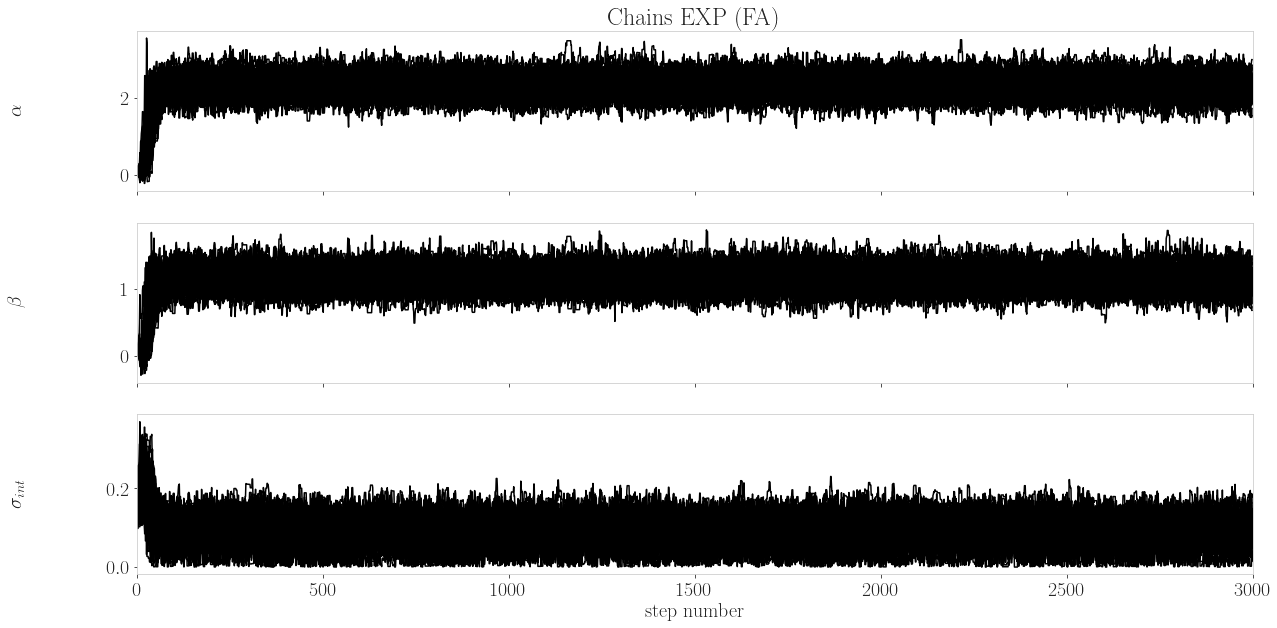

-78.29434363444021


100%|███████████████████████████████████████| 3000/3000 [01:33<00:00, 32.11it/s]


48.50058705378469
0.6427966666666667


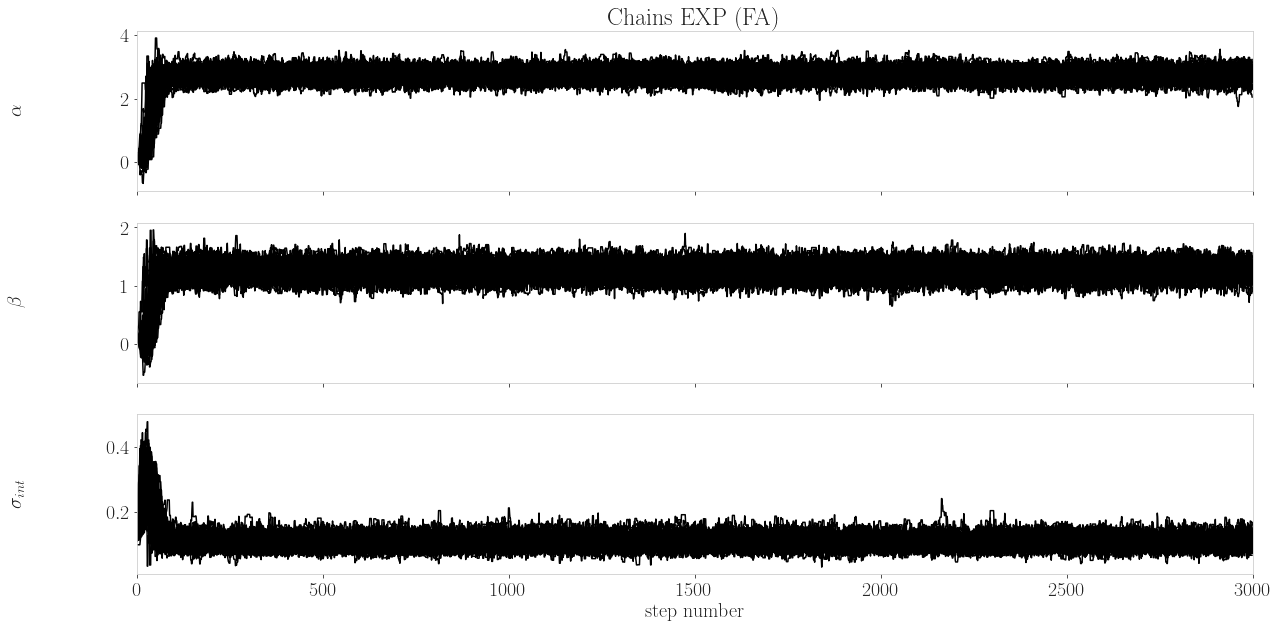

-56.61535380092659


100%|███████████████████████████████████████| 3000/3000 [01:32<00:00, 32.29it/s]


40.31527960048155
0.6437533333333334


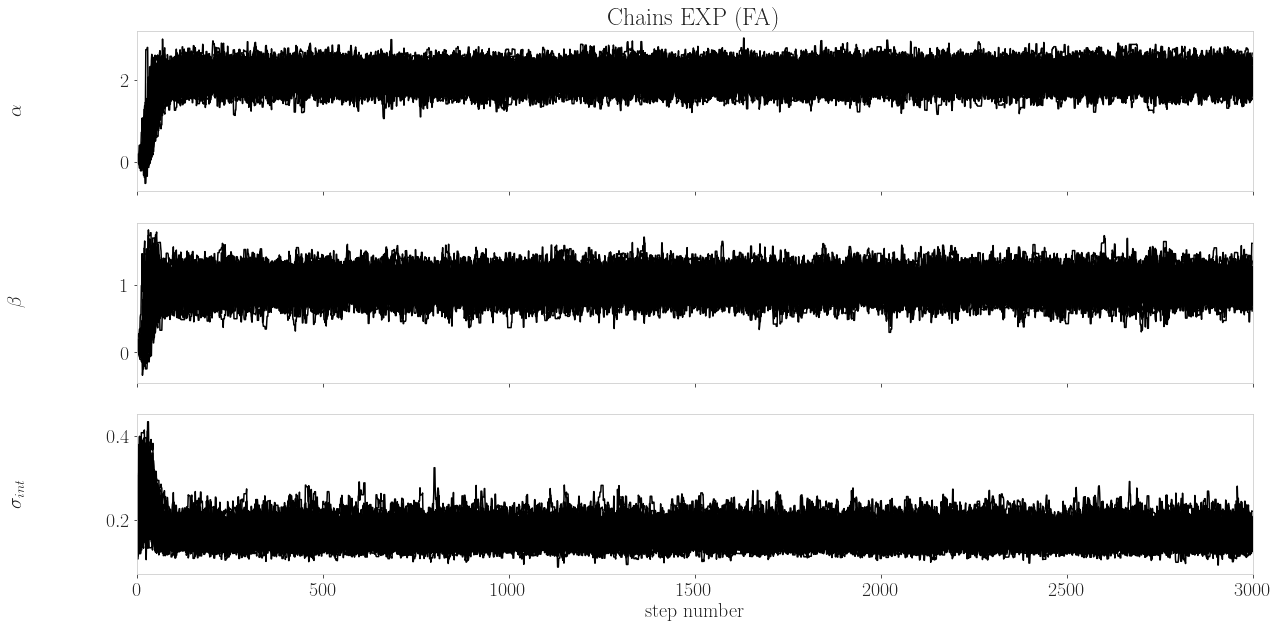

-47.71656313432279


100%|███████████████████████████████████████| 3000/3000 [01:35<00:00, 31.44it/s]


42.57903191241402
0.6431766666666667


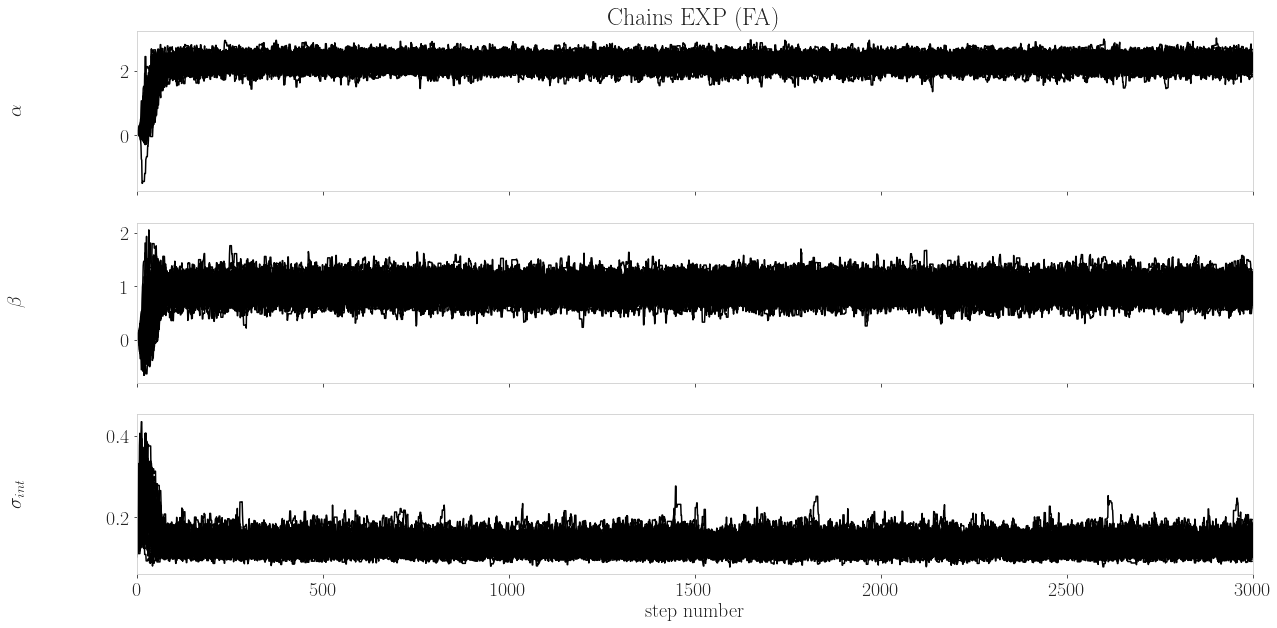

-21.319111952811912


100%|███████████████████████████████████████| 3000/3000 [01:32<00:00, 32.47it/s]


40.48582248915311
0.6451266666666667


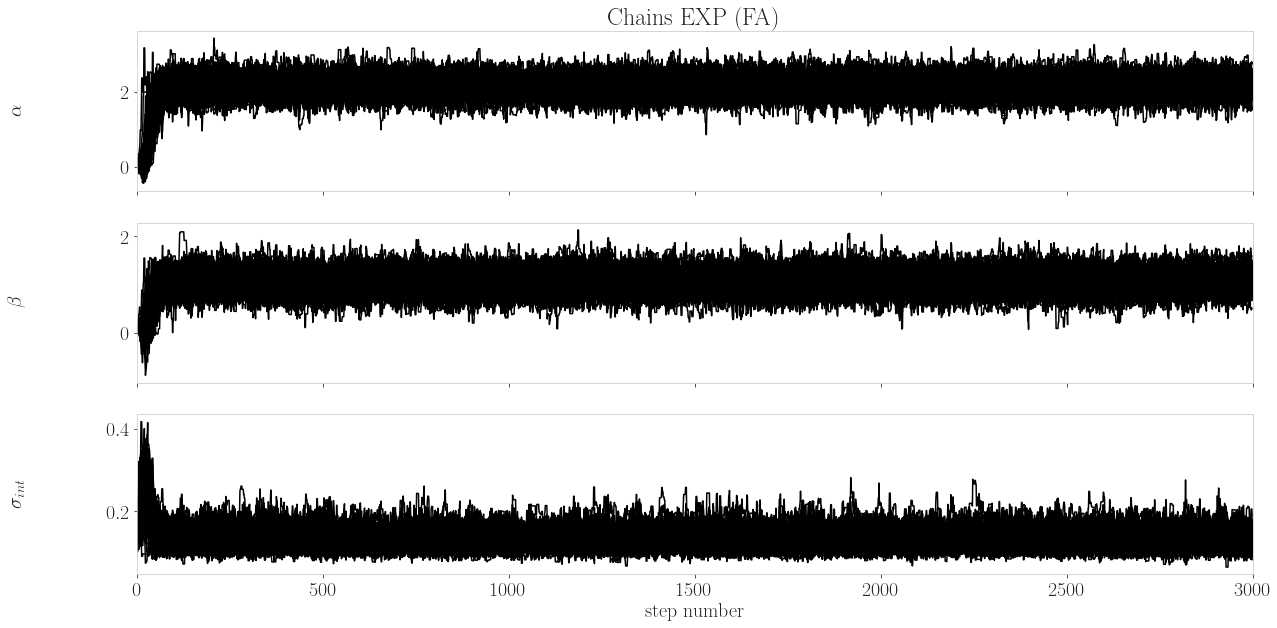

-27.022331401857542


 23%|█████████▎                              | 699/3000 [00:22<01:11, 32.00it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|███████████████████████████████████████| 3000/3000 [01:33<00:00, 31.99it/s]


41.75223118312777
0.6447033333333334


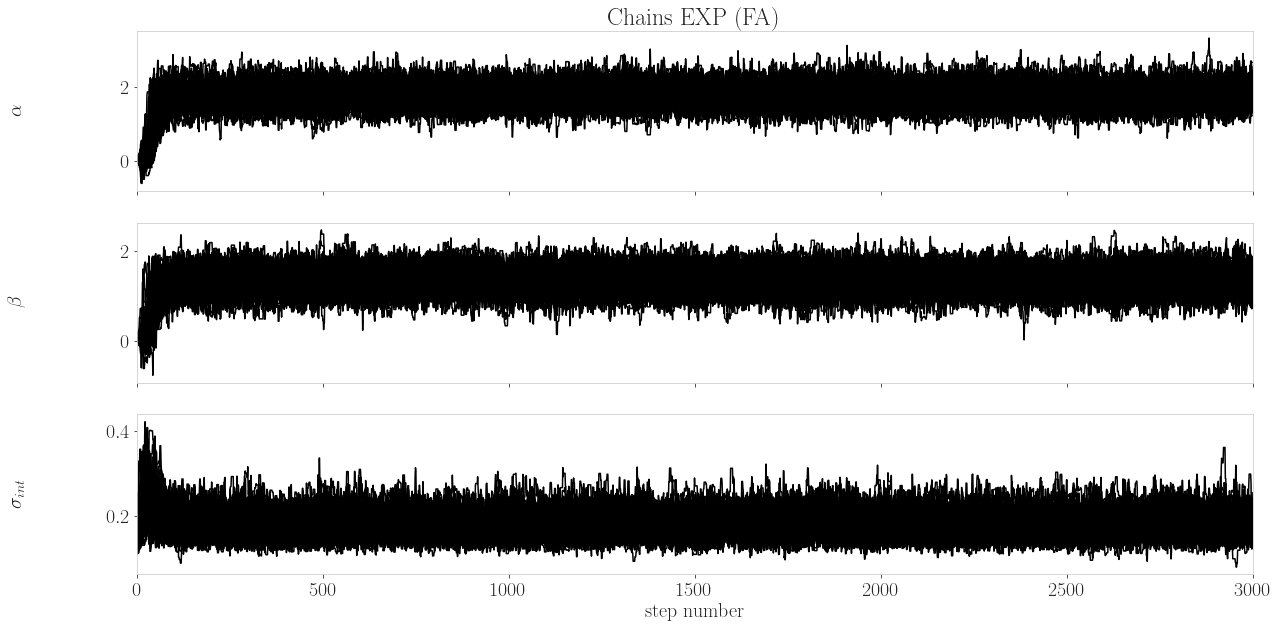

-25.72722588714241


100%|███████████████████████████████████████| 3000/3000 [01:33<00:00, 32.10it/s]


41.22214503566983
0.6453266666666667


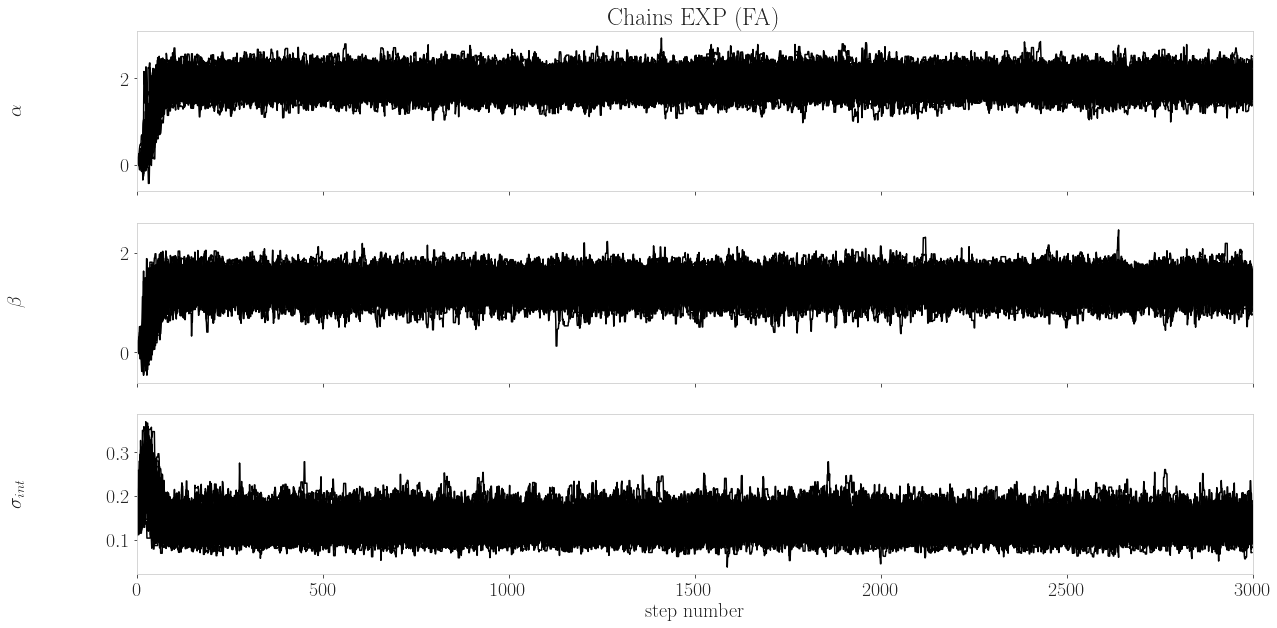

-36.69798596573637


  1%|▍                                        | 28/3000 [00:01<01:44, 28.45it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|███████████████████████████████████████| 3000/3000 [01:33<00:00, 31.99it/s]


39.55674485187141
0.6462433333333333


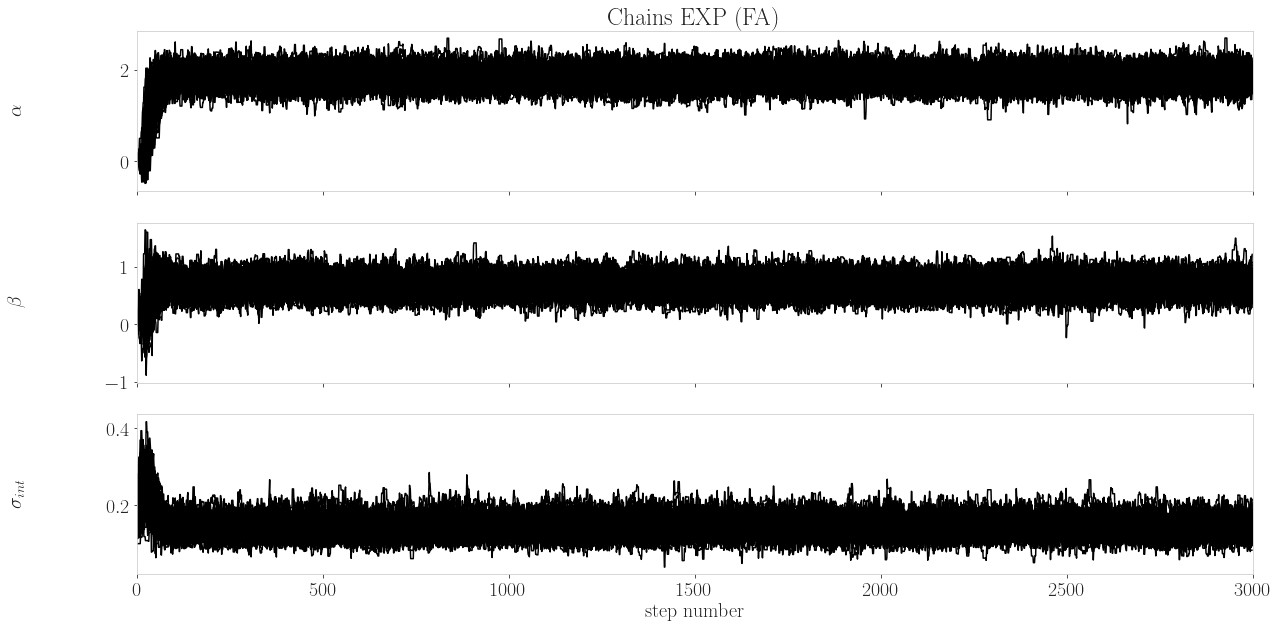

-74.79867626806316


100%|███████████████████████████████████████| 3000/3000 [01:37<00:00, 30.91it/s]


41.53752888496964
0.64319


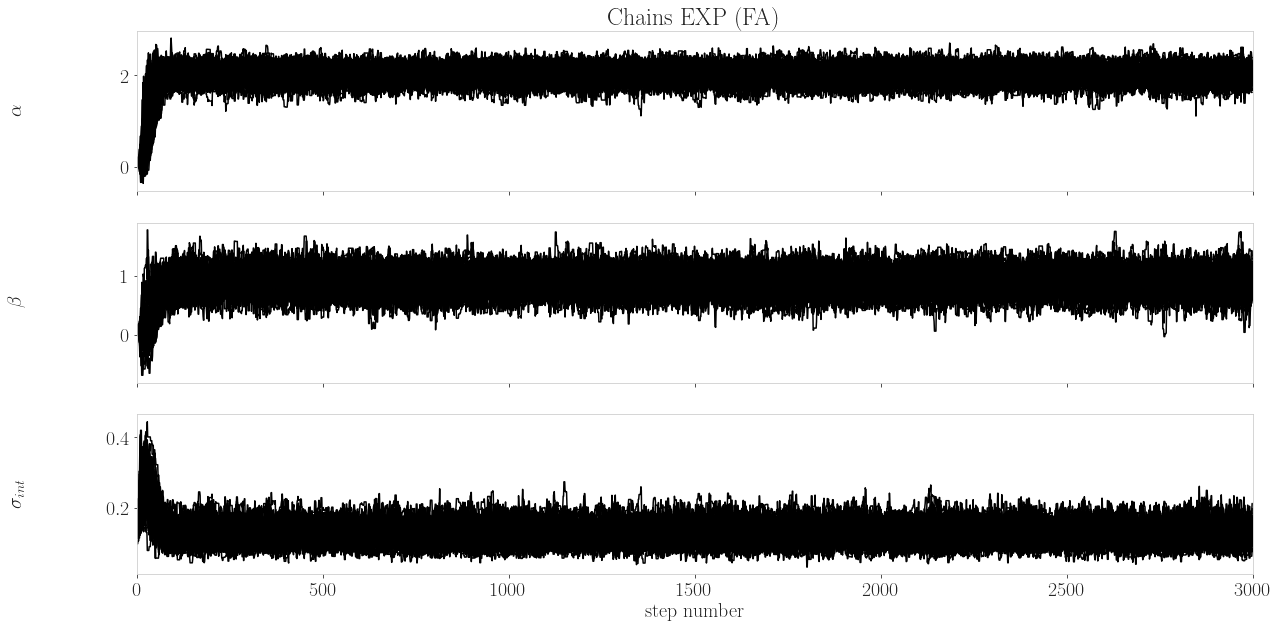

-41.17257371491725


100%|███████████████████████████████████████| 3000/3000 [01:34<00:00, 31.86it/s]


40.94554774711901
0.6454033333333332


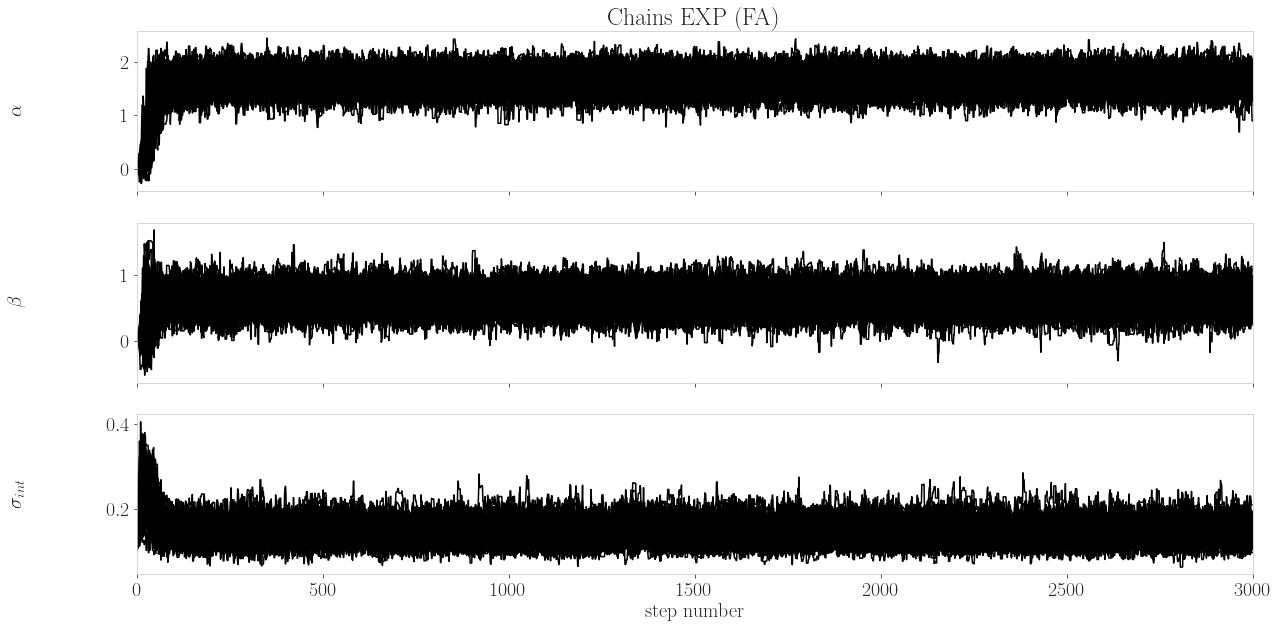

-29.637353510333988


100%|███████████████████████████████████████| 3000/3000 [01:33<00:00, 32.06it/s]


39.9473697081159
0.6447200000000001


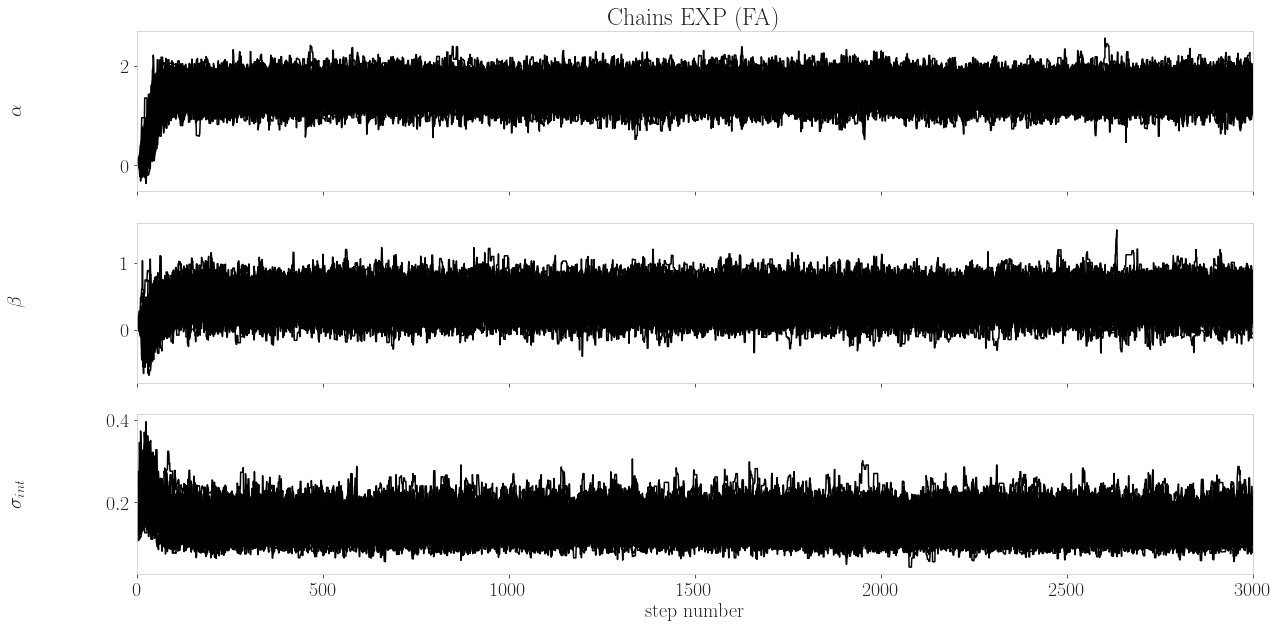

-35.62632316708085


100%|███████████████████████████████████████| 3000/3000 [01:33<00:00, 32.04it/s]


37.003332123128914
0.6444033333333333


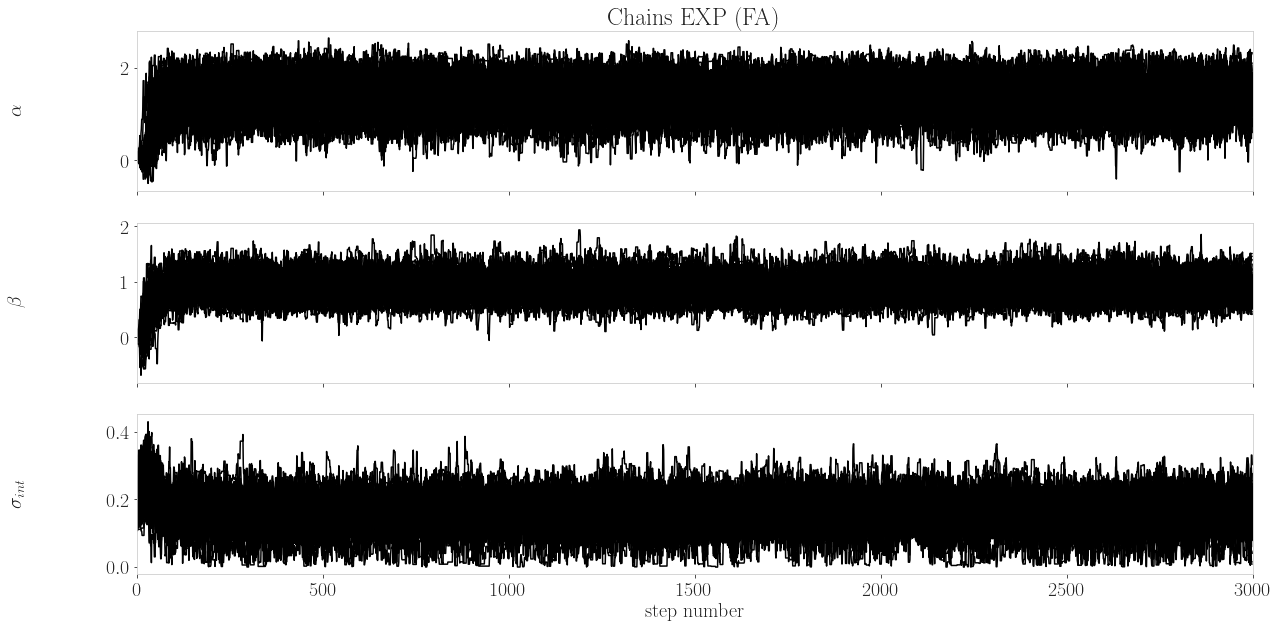

-19.99032379535427


100%|███████████████████████████████████████| 3000/3000 [01:33<00:00, 31.92it/s]


39.168795890122915
0.6451399999999999


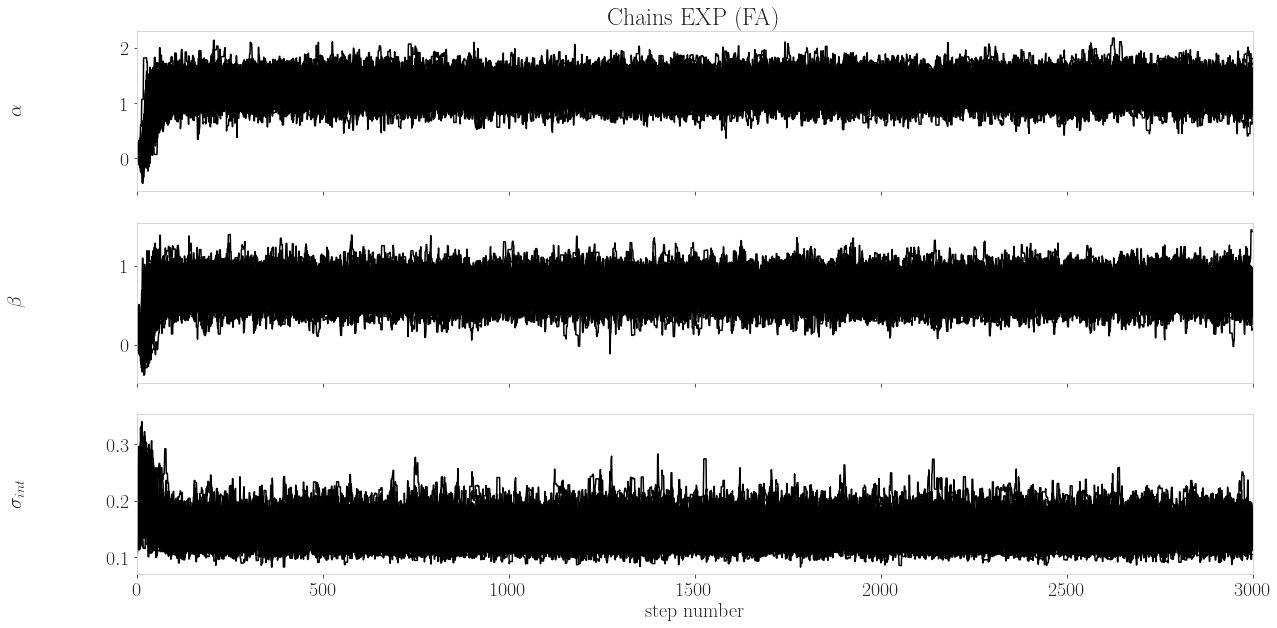

-57.421924568254276


100%|███████████████████████████████████████| 3000/3000 [01:36<00:00, 30.96it/s]


39.19534503659762
0.6441166666666667


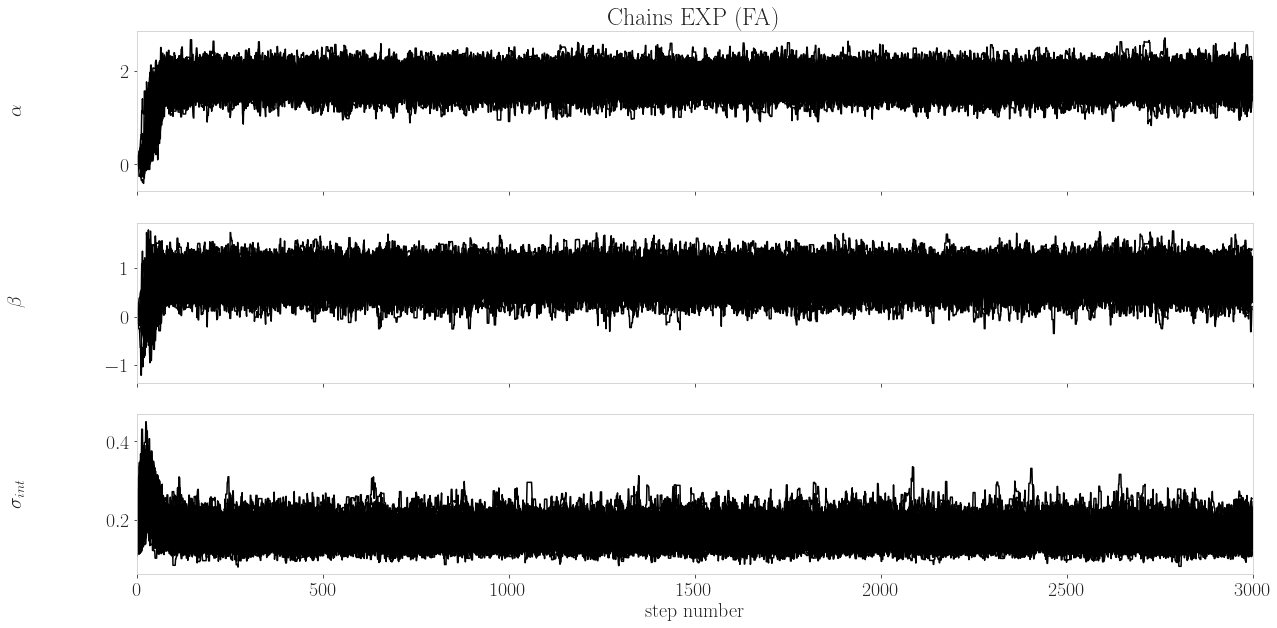

-42.87291703439602


100%|███████████████████████████████████████| 3000/3000 [01:34<00:00, 31.67it/s]


41.73754200649451
0.6435933333333334


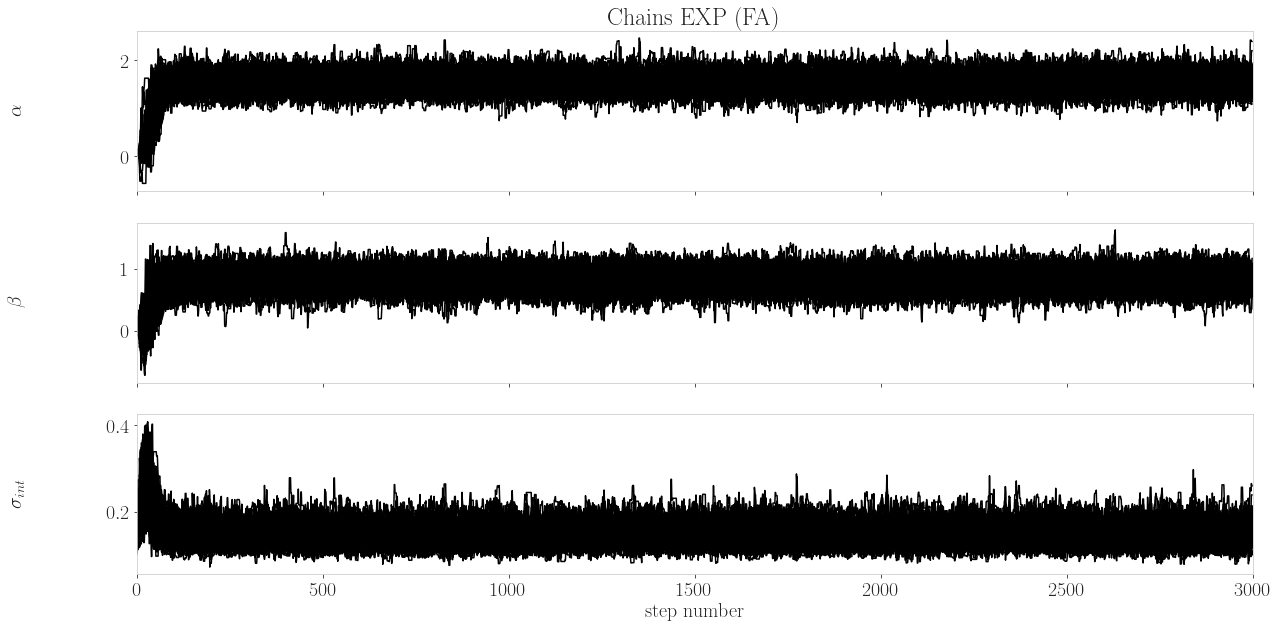

-41.2437917176919


  1%|▍                                        | 32/3000 [00:01<01:49, 27.11it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  1%|▍                                        | 35/3000 [00:01<01:52, 26.36it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  2%|▋                                        | 47/3000 [00:

43.37912555286034
0.6428100000000001


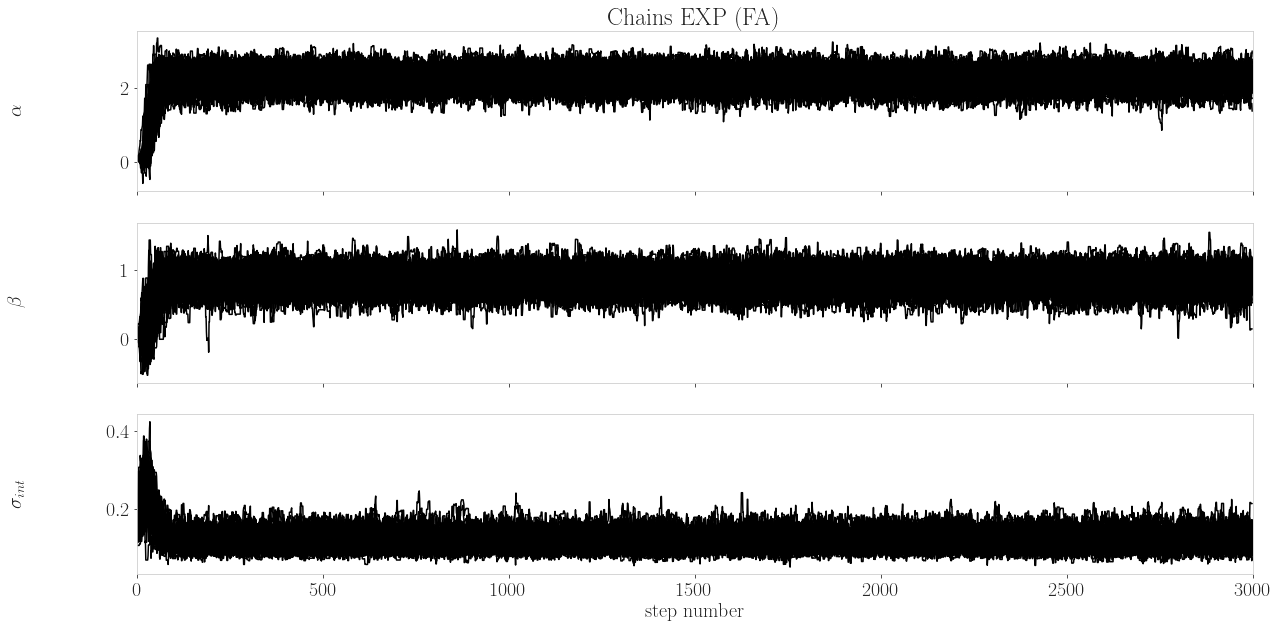

-4.738884839582423


100%|███████████████████████████████████████| 3000/3000 [01:33<00:00, 32.13it/s]


36.600510053800996
0.6470466666666665


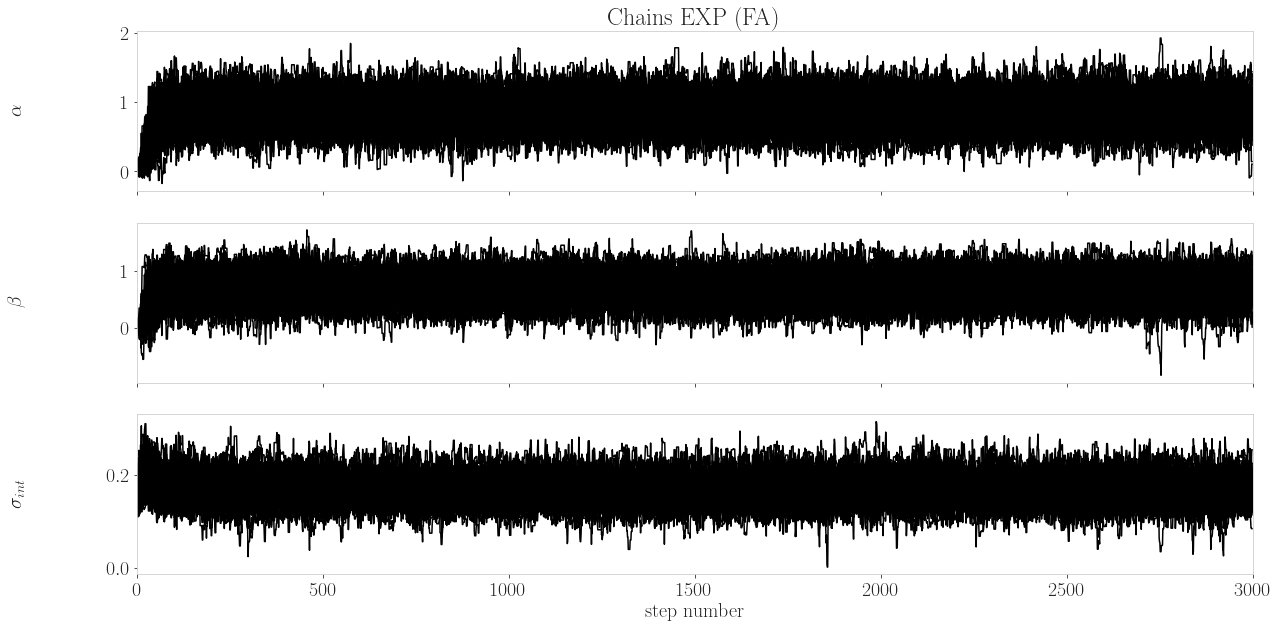

-21.987338417352177


100%|███████████████████████████████████████| 3000/3000 [01:33<00:00, 32.18it/s]


35.43462964586612
0.6464033333333333


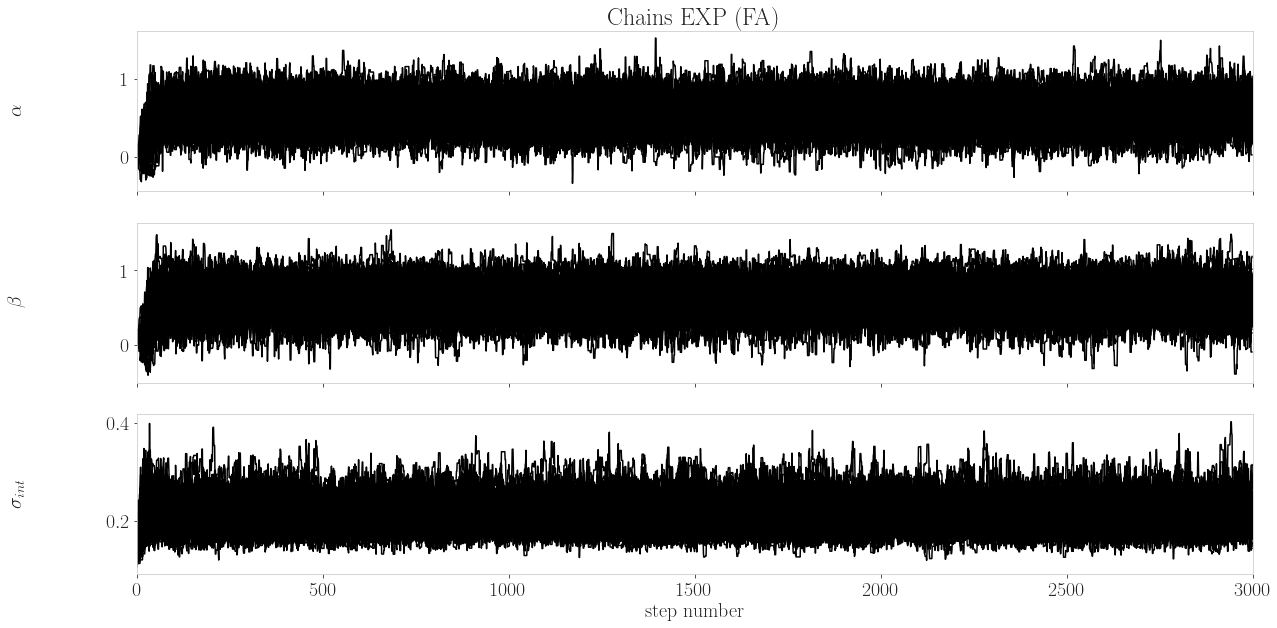

In [27]:
for j,dat in enumerate([intervalo1,intervalo2,intervalo3,intervalo4,intervalo5,intervalo6,intervalo7,intervalo8,intervalo9,intervalo10,intervalo11,intervalo12,intervalo13,intervalo14,intervalo15,intervalo16,intervalo17,intervalo18]):
    cosmo_exp=cosmo(dat)
    print(cosmo_exp.log_probability_exp([0.08,0.08,0.13]))
    pos = np.array([0.08,0.08,0.13])+0.01 *np.random.randn(100, 3)
    nwalkers, ndim = pos.shape
    
    with Pool() as pool:
        sampler_exp = emcee.EnsembleSampler(nwalkers, ndim, cosmo_exp.log_probability_exp, pool=pool)
        sampler_exp.run_mcmc(pos, 3000, progress=True)
    
    print(np.mean(sampler_exp.get_autocorr_time()))
    
    print(np.mean(sampler_exp.acceptance_fraction))
    
    fig, axes = plt.subplots(ndim, figsize=(20, 10), sharex=True)
    samples_exp = sampler_exp.get_chain()
    labels = [r"$\alpha$",r"$\beta$",r"$\sigma_{int}$"]

    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples_exp[:, :, i], "k")
        ax.set_xlim(0, len(samples_exp))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.grid(False)
        if i==0:
            ax.set_title("Chains EXP FA")

    
    axes[-1].set_xlabel("step number");
    
    plt.show()
    
    flat_samples_exp = sampler_exp.get_chain(discard=500, thin=10, flat=True)
    
    np.savetxt("./chains_evol_w_z_FA/chain_int"+str(j)+"_FA.txt",flat_samples_exp)